In [1]:
# 필요한 모듈 불러오기
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import glob

# 필요한 모듈 가져오기
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline

In [2]:
# 이미지 형식의 파일을 input값으로 받는다
# 이때 이미지의 size는 Galaxy Note9의 2160 X 2160
def imgSlicingProcess(img):
  
  # 이미지 형식 데이터 -> array 형식으로 변환
  # (2112 * 2112)/(64*64) = 1089장
  # 위의 계산이 떨어지도록 여백을 잘라낸다.
  # 1장의 이미지로부터 1089장 이미지 획득
    
  # 이미지 처리 과정
  
  STEP = 64 # 이미지의 가로 세로 크기
  X_TOT_CNT = 11 # 이미지의 가로 칸수
  Y_TOT_CNT = 11 # 이미지의 세로 칸수
  
  img_list = list()
  for Y_CNT in range(Y_TOT_CNT):
    for X_CNT in range(X_TOT_CNT):
      
      # 이미지 담기
      sliced_img = img[0 + STEP*Y_CNT : STEP*(0+Y_CNT+1), 0 + STEP*X_CNT : STEP*(0+X_CNT+1),:]
      img_list.append(sliced_img)
    
  return img_list

In [55]:
def imgPreprocessing(src, blocksize, sub):
    ############################################################################
    # <이미지 노이즈 및 배경 제거>

    # 그레이 스케일로 변환
    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    
    # 데이터형 변환
    img_tensor = torch.LongTensor(np.array(img))

    # 바이너리로 변환
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, sub)
    # ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # 바이너리 이미지와 원본 이미지의 데이터가 일치하는 부분 만 다시 추출히기
    # tmp = np.zeros_like(src)
    # for i in range(3):
    #     tmp[:,:,i] = (src[:,:,i] * binary)

    tmp = np.zeros_like(src)
    for y in range(64):
        for x in range(64):
            if (binary != 0)[y,x]:
                for i in range(3):
                    tmp[y,x,i] = src[y,x,i]
    
    src_processed = tmp

    height = src_processed.shape[0]
    width = src_processed.shape[1]

    ############################################################################
    # <생두 무게 중심 구하기>
    R = list()
    for y in range(height):
        for x in range(width):
            if binary[y,x]:            
                R.append([x, (height-y)*1j])

    # 질량의 합
    M = len(R)

    # 질량중심 벡터는 이미지를 기준으로 (x,y) => (height-y)
    R = np.array(R)
    R_x = R[:,0]
    R_y = R[:,1]

    R_x_sum = R_x.sum()
    R_y_sum = R_y.sum()

    center = np.round(R_x_sum/M).real , (np.round(R_y_sum/M)*-1j).real
    
    height_center = center[1]
    width_center = center[0]

    ############################################################################
    # <이미지의 중심과 생두의 무게중심 일치시키기>
    
    # 1. 이미지 센터 좌표를 구한다 
    src_center = np.array([src_processed.shape[1] / 2, src_processed.shape[0] / 2]) # (x, y)

    # 2. 객체의 중심을 구한다
    object_center = np.array([height_center, width_center]) # (x, y)

    # 3. 이미지 중심과 객체의 중심의 차이를 구한다
    delta = object_center - src_center # (x, y)

    # 4. 이미지 이동
    height, width = src_processed.shape[:2]
    M = np.float32([[1, 0, -delta[1]], [0, 1, delta[0]]]) # 이미지를 width 방향으로 delta[0]만큼 , hiehgt 방향으로 -delta[1]만큼
    img_translation = cv2.warpAffine(src_processed, M, (width,height))

    return src, binary, src_processed, img_translation

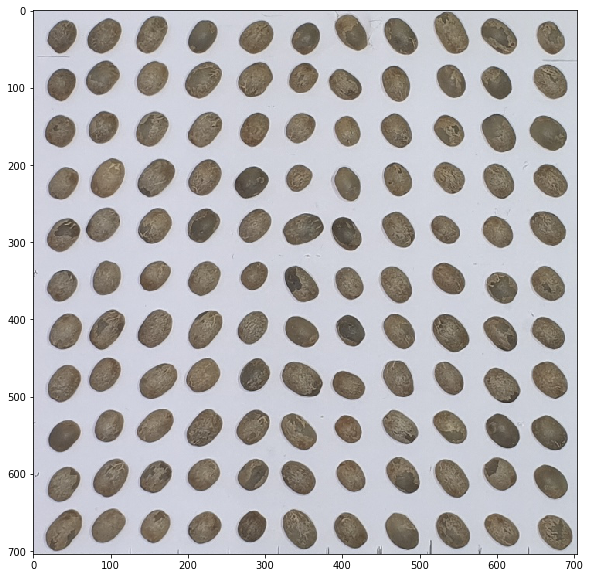

In [56]:
# 이미지 불러오기
img = Image.open('.\\data\\normal_data\\real_data_normal\\20200518_take14.jpg')
img = np.array(img)
# img = cv2.imread('.\\data\\20200512_test_re1.jpeg', cv2.IMREAD_UNCHANGED)
img_final = img[740:1444,713:1417,:]
plt.figure(figsize=(10,10))
plt.imshow(img_final)
# cv2.imwrite('.\\data\\ROI.jpg', img_final)

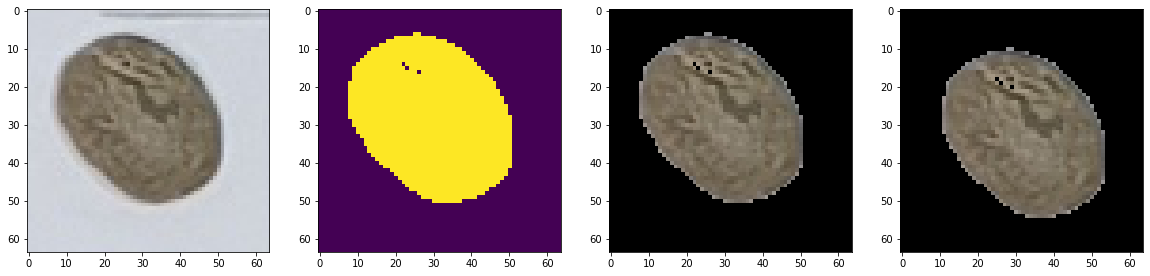

In [58]:
img_list = imgSlicingProcess(img_final)
fig = plt.figure(figsize=(20,40))
for i in range(len(imgPreprocessing(img_list[21],501,50))):
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(imgPreprocessing(img_list[21],501,50)[i])